In [107]:
from collections import defaultdict
import itertools
import string
import pandas as pd
import numpy as np
import copy
import random
import time

class Tower:
    def __init__(self, pegs, discs, state=None):
        self.pegs = pegs
        self.discs = discs
        self.start_discs = [i + 1 for i in range(discs)]
        pegs = [string.ascii_uppercase[i] for i in range(pegs)]
        self.test = pegs
        self.board = {key:[] for key in pegs}
        self.board[pegs[0]] = self.start_discs
        self.start_discs = pegs
        if state != None:
            self.board = state
        
    def check(self):
        print(self.board)
        
    def valid(self, start, end):
        """
        Helper function to check for valid moves
        """
        if self.board[start] == []:
            return False
        elif self.board[end] == []:
            return True
        elif self.board[start][0] < self.board[end][0]:
            return True
        else:
            return False
        
    def solved(self):
        last = string.ascii_uppercase[self.pegs - 1]
        if len(self.board[last]) == self.discs:
            return True
        else:
            return False
        
    def move(self, start, end):
        """
        Moves the discs from one peg to another
        """
        print("   ", self.board[start], self.board[end])
        if self.valid(start,end):
            disc = self.board[start].pop(0)
            self.board[end].insert(0, disc)
        else:
#            print("Invalid move")
            return False
        if self.solved():
            print("You Win!")
            self.check()
        return True
    
    def move_explore(self, start, end):
        """
        Moves the discs from one peg to another
        """
        if self.valid(start,end):
            board = copy.deepcopy(self.board)
            disc = board[start].pop(0)
            board[end].insert(0, disc)
            return board
        else:
            return False
            
    def make_states(self):
        states = list(itertools.product(list(range(self.pegs)), repeat=self.discs))
        all_states = []
        for i in states:
            temp = [[] for x in range(self.pegs)]
            disc = self.discs
            for j in i:
                temp[j].insert(0, disc)
                disc -= 1
            z = list(zip(self.test, [k for k in temp]))
            state = defaultdict(list)
            for key, value in z:
                state[key] = value
            all_states.append(state)
        return all_states
          
    def make_moves(self):
        moves = list(itertools.permutations(self.start_discs, 2))
        return moves
    
    def make_state_space(self):
        moves = self.make_moves()
        states = self.make_states()
        total = 0
        keys = []
        for d in states:
            keys.append(tuple(tuple(v) for v in d.values()))
        rewards = pd.DataFrame(index=keys, columns=keys, data= -np.inf)
        for state in states:
            for move in moves:
                start = copy.deepcopy(tuple(tuple(i) for i in state.values()))
                explore = Tower(self.pegs, self.discs, state)
                check = explore.valid(move[0],move[1])
                if check:
                    end = explore.move_explore(move[0],move[1])
                    end = tuple(tuple(i) for i in end.values())
                    if explore.solved():
                        rewards[start][end] = 100
                    else:
                        rewards[start][end] = 0
        return rewards
                

In [108]:
test = Tower(3, 4)
#test.check()
#test.move('A',"C")
#test.move('A',"B")
#test.move('C',"B")
#test.move('A',"C")
#test.move('B',"A")
#test.move('B',"C")
#test.move('A',"C")
R = test.make_state_space()

In [109]:
#states=list(range(R.shape[0]))
#Q = np.zeros(R.shape)
#states = R.columns

In [110]:
def learning(R, alpha, gamma, episodes):
    states=list(range(R.shape[0]))
    Q = np.zeros(R.shape)
    states = R.columns
    episodes = 0
    while np.max(Q[0]) == 0:
#    for x in range(episodes):
        episodes += 1
        state = np.random.choice(states) # random starting state
        next_states = np.where(R[state] >= 0)[0] # the index of the states that are not zero
        next_state = np.random.choice(next_states) # the index to the state 
        future = np.max(Q[next_state,:])
        start_state = list(states).index(state) # index of the start state
        nex = states[next_state]
        Q[start_state, next_state] = (1-alpha)*Q[start_state,next_state] + alpha*(R[nex][state] + gamma*future)
    print(np.max(Q[0]))
    Q /= np.max(Q)
    print(episodes)
    return Q

In [111]:
def learning2(R, alpha, gamma, epsilon, trials=1):
    states=list(range(R.shape[0]))
    Q = np.zeros(R.shape)
    states = R.columns
    episodes = 0
    nex = states[0]
    while np.max(Q[0]) == 0 or episodes < trials:
        state = states[0]
        episodes += 1
        while (state != states[-1]):
            next_states = np.where(R[state] >= 0)[0] # the index of the states that are not -inf
            start_state = list(states).index(state) # index of the start state
            if random.random() > epsilon or (np.argmax(Q[start_state]) <= 0):
                next_state = np.random.choice(next_states) # the index to the state
            else:
                np.argmax(Q[start_state])
            future = np.max(Q[next_state,:])
            nex = states[next_state] # end state 
            Q[start_state, next_state] = (1-alpha)*Q[start_state,next_state] + alpha*(R[nex][state] + gamma*future)
            state = nex
    Q /= np.max(Q)
    return Q, episodes

In [112]:
#Q = learning(R, .9, .8, 1000)
#Q, _ = learning2(R, .5, .5, .1)
#print(len(Q)**2)
#count = 0
#for i in Q:
#    for j in i:
#        if j > 0:
#            count += 1
#print(count)

In [113]:
def get_policy(Q, R):
    policy = []
    for i in range(Q.shape[0]):
        row = Q[i,:]
        sorted_vals = np.sort(row)
        sorted_vals = sorted_vals[~np.isnan(sorted_vals)][::-1]
        sorted_args = row.argsort()[np.where(~np.isnan(sorted_vals))][::-1]
        max_vals = [val for val in sorted_vals if val==sorted_vals[0]]
        max_args = [sorted_args[i] for i,val in enumerate(sorted_vals) if val==sorted_vals[0]]
        policy.append(max_args)
    return policy

In [114]:
policy = get_policy(Q,R)


In [115]:
def play(policy):
    start_state = 0
    end_state = len(policy)-1
    state = start_state
    moves = 0
    while state != end_state:
        state = np.random.choice(policy[state])
#        print(R.columns[state])
        moves += 1
    return moves
#print(play(policy))
play(policy)

11

In [116]:
def time_algorithm(algorithm, R, a, g, e, t):
    episodes = 0
    moves = 0
    for x in range(50):
        Q, E = algorithm(R, a,g,e,t)
        policy = get_policy(Q, R)
        moves += play(policy)
        episodes += E
    return (moves / 50, episodes / 50)

#alpha_test = []
#for i in range(18):
#    x, y = (time_algorithm(learning2, R, .05 * (i + 1), .9, .1 , 1))
#    print(x, y)
#    alpha_test.append((x,y))

16.42 8.02
16.32 7.66
16.62 7.82
16.56 7.8
16.82 7.48
16.76 7.52
17.54 7.72
16.76 7.7
16.8 7.68
17.72 7.38
17.48 7.88
16.58 7.94
16.76 8.18
16.88 7.88
16.78 7.7
16.7 7.72
16.64 8.24
16.02 7.54


In [117]:
#gamma_test = []
#for i in range(18):
#    x, y = (time_algorithm(learning2, R, .9, .05 * (i + 1), .1 , 1))
#    print(x, y)
#    gamma_test.append((x,y))

16.5 7.92
15.38 7.54
16.16 8.06
15.7 8.1
16.44 8.22
16.26 7.8
15.72 7.72
15.46 7.9
15.82 7.28
15.32 7.8
16.08 8.16
15.68 7.68
15.86 8.08
16.04 7.68
15.52 7.98
16.54 8.12
17.2 8.04
15.88 7.92


In [118]:
#epsilon_test = []
#for i in range(20):
#    x, y = (time_algorithm(learning2, R, .9, .9, .05 * i , 1))
#    print(x, y)
#    epsilon_test.append((x,y))

16.84 7.64
17.04 7.34
16.66 8.3
16.76 7.18
16.14 7.86
16.52 7.92
16.32 7.84
16.16 7.84
15.76 7.86
15.84 7.54
16.74 7.8
15.56 7.88
16.46 7.2
16.1 7.94
16.26 8.4
16.24 8.16
16.78 7.98
16.08 8.12
16.74 8.16
16.6 7.8


In [119]:
#episode_test1 = []
#episode_test2 = []
#for i in range(30):
#    x, y = (time_algorithm(learning2, R, .9, .9, .1, i))
#    print(x, y)
#    episode_test1.append((x,y))
#    
#for i in range(30):
#    x, y = (time_algorithm(learning2, R, .9, .9, .9, i))
#    print(x, y)
#    episode_test2.append((x,y))

16.84 7.52
16.08 7.54
16.3 7.64
16.0 7.7
15.98 8.5
16.72 7.88
16.16 7.98
16.28 7.92
15.52 8.48
15.36 9.36
15.32 10.12
15.12 11.12
15.16 12.08
15.34 13.02
15.0 14.0
15.02 15.0
15.0 16.0
15.0 17.0
15.0 18.0
15.0 19.0
15.0 20.0
15.0 21.0
15.0 22.0
15.0 23.0
15.0 24.0
15.0 25.0
15.0 26.0
15.0 27.0
15.0 28.0
15.0 29.0
15.98 7.46
16.44 7.68
15.3 7.74
16.44 7.86
16.6 8.08
15.88 7.98
16.8 8.06
16.14 8.66
16.34 8.92
16.16 9.36
16.42 10.12
15.94 11.22
16.1 12.02
16.34 13.0
16.14 14.0
16.0 15.0
15.58 16.0
15.84 17.0
15.56 18.0
16.02 19.0
15.64 20.0
15.94 21.0
15.62 22.0
15.68 23.0
15.52 24.0
16.04 25.0
15.42 26.0
15.26 27.0
15.84 28.0
15.18 29.0


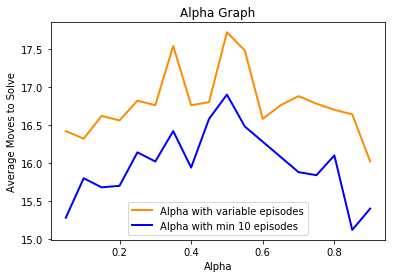

In [144]:
import matplotlib.pyplot as plt

test = alpha_test
test2 = alpha_test2

plt.figure()
lw = 2
plt.plot([(i+1) * .05 for i in range(len(test))], [j for j,_ in test], color='darkorange',
         lw=lw, label='Alpha with variable episodes')
plt.plot([(i+1) * .05 for i in range(len(test))], [j for j,_ in test2], color='blue',
         lw=lw, label='Alpha with min 10 episodes')
plt.xlabel('Alpha')
plt.ylabel('Average Moves to Solve')
plt.title('Alpha Graph')
plt.legend(loc="lower center")
plt.show()


0.469730681966
0.166833250083


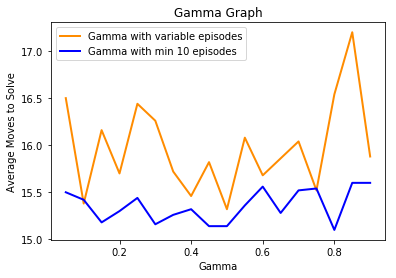

In [170]:
import matplotlib.pyplot as plt

test = gamma_test
test2 = gamma_test2

print(np.std([j for j,_ in test]))
print(np.std([j for j,_ in test2]))

plt.figure()
lw = 2
plt.plot([(i+1) * .05 for i in range(len(test))], [j for j,_ in test], color='darkorange',
         lw=lw, label='Gamma with variable episodes')
plt.plot([(i+1) * .05 for i in range(len(test))], [j for j,_ in test2], color='blue',
         lw=lw, label='Gamma with min 10 episodes')
plt.xlabel('Gamma')
plt.ylabel('Average Moves to Solve')
plt.title('Gamma Graph')
plt.legend(loc="upper left")
plt.show()


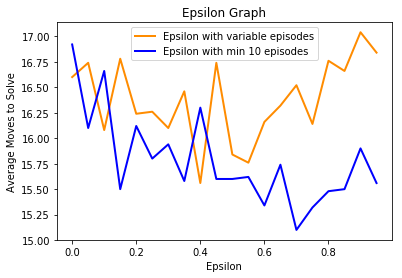

In [161]:
import matplotlib.pyplot as plt

test = epsilon_test
test2 = epsilon_test2
test.reverse()
test2.reverse()

plt.figure()
lw = 2
plt.plot([i * .05 for i in range(len(test))], [j for j,_ in test], color='darkorange',
         lw=lw, label='Epsilon with variable episodes')
plt.plot([i * .05 for i in range(len(test2))], [j for j,_ in test2], color='blue',
         lw=lw, label='Epsilon with min 10 episodes')
plt.xlabel('Epsilon')
plt.ylabel('Average Moves to Solve')
plt.title('Epsilon Graph')
plt.legend(loc="upper center")
plt.show()


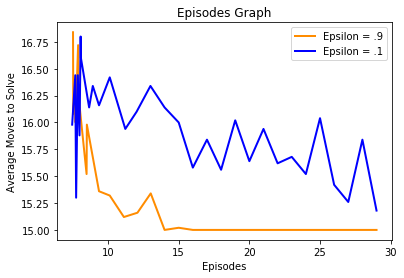

In [147]:
import matplotlib.pyplot as plt

test1 = sorted(episode_test1, key=lambda tup: tup[1])
test2 = sorted(episode_test2, key=lambda tup: tup[1])
#test1 = episode_test1
#test2 = episode_test2

plt.figure()
lw = 2
plt.plot([i for _,i in test1], [j for j,_ in test1], color='darkorange',
         lw=lw, label='Epsilon = .9')
plt.plot([i for _,i in test2], [j for j,_ in test2], color='blue',
         lw=lw, label='Epsilon = .1')
plt.xlabel('Episodes')
plt.ylabel('Average Moves to Solve')
plt.title('Episodes Graph')
plt.legend(loc="upper right")
plt.show()

In [129]:
alpha_test2 = []
for i in range(18):
    x, y = (time_algorithm(learning2, R, .05 * (i + 1), .9, .1 , 10))
    print(x, y)
    alpha_test2.append((x,y))

15.28 10.04
15.8 10.26
15.68 10.26
15.7 10.4
16.14 10.28
16.02 10.32
16.42 10.16
15.94 10.14
16.58 10.28
16.9 10.12
16.48 10.32
16.28 10.22
16.08 10.22
15.88 10.14
15.84 10.22
16.1 10.26
15.12 10.08
15.4 10.18


In [130]:
gamma_test2 = []
for i in range(18):
    x, y = (time_algorithm(learning2, R, .9, .05 * (i + 1), .1 , 10))
    print(x, y)
    gamma_test2.append((x,y))

15.5 10.12
15.42 10.2
15.18 10.28
15.3 10.24
15.44 10.02
15.16 10.36
15.26 10.32
15.32 10.2
15.14 10.58
15.14 10.22
15.36 10.16
15.56 10.28
15.28 10.2
15.52 10.16
15.54 10.2
15.1 10.18
15.6 10.24
15.6 10.24


In [135]:
epsilon_test2 = []
for i in range(20):
    x, y = (time_algorithm(learning2, R, .9, .9, .05 * i , 10))
    print(x, y)
    epsilon_test2.append((x,y))

15.56 10.36
15.9 10.18
15.5 10.26
15.48 10.26
15.32 10.24
15.1 10.06
15.74 10.42
15.34 10.24
15.62 10.14
15.6 10.36
15.6 10.22
16.3 10.24
15.58 10.04
15.94 10.06
15.8 10.2
16.12 10.16
15.5 10.26
16.66 10.2
16.1 10.06
16.92 10.12


In [169]:
best = []
for i in range(20):
    start = time.time()
    x, y = (time_algorithm(learning2, R, .05, .9, .25 , i))
    end = time.time()
    print(x, y, (end-start))
    best.append((x,y))

16.18 8.16 115.09281754493713
15.74 7.58 115.33010697364807
16.68 7.98 127.89803051948547
15.84 8.14 116.8201072216034
16.24 7.7 111.16082811355591
16.36 7.8 123.03403329849243
16.06 7.8 123.85619330406189
15.7 8.58 127.89758229255676
15.9 8.72 135.6594741344452
15.42 9.34 145.52370738983154
15.4 10.34 134.34205508232117
15.58 11.08 162.10762572288513
15.18 12.04 177.0402615070343
15.28 13.0 174.56020855903625
15.28 14.02 195.0643663406372
15.16 15.0 193.29193139076233
15.02 16.0 212.4984953403473
15.06 17.0 247.4888162612915
15.0 18.0 239.89465832710266
15.0 19.0 244.29406547546387


In [168]:
best2 = []
for i in range(20):
    start = time.time()
    x, y = (time_algorithm(learning2, R, .95, .9, .25 , i))
    end = time.time()
    print(x, y, (end-start))
    best.append((x,y))

16.24 7.44 119.23155045509338
15.9 8.28 116.63116669654846
15.88 8.3 111.75228810310364
16.02 8.14 96.77707839012146
15.98 8.3 106.40254187583923
16.64 7.68 106.42197751998901
16.06 7.82 100.35104084014893
15.38 8.46 106.55158281326294
15.36 8.78 116.59809827804565
15.66 9.2 124.53073358535767
15.44 10.3 120.69868063926697
15.08 11.08 133.56463027000427
15.12 12.0 155.23644518852234
15.04 13.0 156.7423861026764
15.28 14.0 169.14556503295898
15.02 15.0 198.30439448356628
15.0 16.0 205.92290568351746
15.04 17.0 232.2870738506317
15.02 18.0 236.04539442062378
15.0 19.0 243.44753098487854
